# Plot results and analysis

## Setup

In [66]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

import pickle as pkl
import numpy as np
import os

def pickle_load(path):
    with open(path, "rb") as f:
        return pkl.load(f)
    
SAVE_ROOT = "./figures"
if not os.path.exists(SAVE_ROOT):
    os.makedirs(SAVE_ROOT, exist_ok=True)

clr_palette = {
    "bin0": "#e76254",
    "bin1": "#ffcf6f",
    "bin2": "#72bcd5",
    "baseline": "black",
    "prefixN-indEmb": "#71BFB2",
    "prefixN": "#12776f",
    "RQsum-indEmb": "#553b94" 
}
icon_palette = {
    "baseline": "",
    "prefixN-indEmb": "*",
    "prefixN": "0",
    "RQsum-indEmb": "*"
}
line_palette = {
    "baseline": "-",
    "prefixN-indEmb": "-",
    "prefixN": "-",
    "RQsum-indEmb": "-"
}

## 1. Model performance results
These can really be visualized with tensorboard using the saved logs, but just for nice visuals adn more flexibility, I plotted these here using the outputs in logs/

In [140]:
DATASET = "ml-1m"
root = "../logs/{}-l200/{}"
fs = [
    "hstu-sampled-softmax-n128-final-BL.log",
    "hstu-sampled-softmax-n128-final-SID-prefixN-indEmb.log"
  ]
model_names = [
    "baseline", 
    "prefixN-indEmb"
]
eval_metrics = ["NDCG@10", "NDCG@50", "HR@10", "HR@50", "MRR"]
# train_metrics = []

In [141]:
eval_met_full = []
train_loss_full = []
for fname in fs:
    with open(root.format(DATASET, fname), 'r') as f:
        content = f.readlines()

    eval_met_vals = {met: [] for met in eval_metrics}
    train_loss = []
    for ln in content:
        # eval lines
        if ln.startswith("rank 0: eval @ epoch"):
            for met in eval_metrics:
                met_val = -1.0 # maybe there was one split without any sampled movies.
                if met in ln:
                    met_val = float(ln.split(met)[1].split(",")[0].strip())
                eval_met_vals[met].append(met_val)
                
        # train loss lines
        elif ln.startswith(" rank: 0, batch-stat (train):"):
            loss = float(ln.split(":")[-1].strip())
            train_loss.append(loss)
    eval_met_full.append(eval_met_vals)
    train_loss_full.append(train_loss)

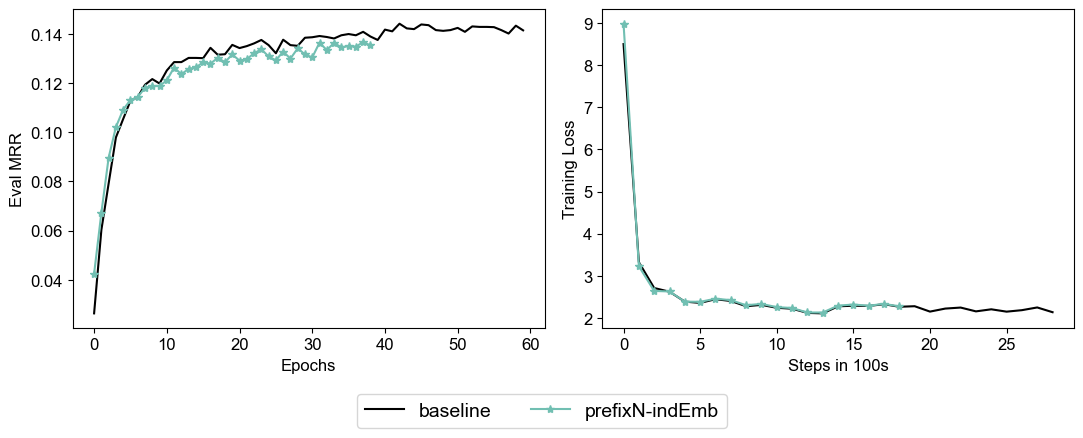

In [145]:
PLOT_METRIC = "MRR"

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
for i, models in enumerate(eval_met_full):
    met_vals = models[PLOT_METRIC]
    axes[0].plot(
        met_vals, 
        label=model_names[i], 
        color=clr_palette[model_names[i]], 
        marker=icon_palette[model_names[i]], 
        linestyle=line_palette[model_names[i]]
    )
    axes[0].set_ylabel(f"Eval {PLOT_METRIC}")
    axes[0].set_xlabel("Epochs")

for i, curr_train_loss in enumerate(train_loss_full):
    axes[1].plot(
        curr_train_loss, 
        label=model_names[i], 
        color=clr_palette[model_names[i]], 
        marker=icon_palette[model_names[i]], 
        linestyle=line_palette[model_names[i]]
    )
    axes[1].set_ylabel("Training Loss")
    axes[1].set_xlabel("Steps in 100s")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)

plt.savefig(f"{SAVE_ROOT}/model_perf_{PLOT_METRIC}_{DATASET}.png", 
            dpi=300, 
            bbox_inches='tight', 
            facecolor=fig.get_facecolor(),
            # transparent=True
            )
plt.tight_layout()
plt.show()

## 2. Semantic ID distribution visualization

Here I'm recreating Figure X in my blog post which examines whether semantic IDs distributions actually correspond to user history. 
Will need to run the analysis/SID_distribution.py first to obtain the distribution data in analysis/

### 2.1 Evaluating RQ-kmeans

In [ ]:
DATASET = "ml-1m"
sid_lookup_pth = f"./tmp/processed/{DATASET}/SID_lookup_L3_C128_uniq.pkl"

### 2.2 Evaluating how predictive SIDs for user behavior

In [149]:
DATASET = "ml-1m"
sid_dist_data = pickle_load(f"./output/SID_distribution_{DATASET}.pkl")
NUM_LAYERS = 4
layer_palette = ["#8074C8", "#7895C1", "#A8CBDF", "#D6EFF4"]

prefix_props = sid_dist_data["full_uniq_cnts_prefix"]
prefix_commonness = [1 - pp for pp in prefix_props]
singledigit_props = sid_dist_data["full_uniq_cnts_singledigit"]
singledigit_commonness = [1 - sp for sp in singledigit_props]

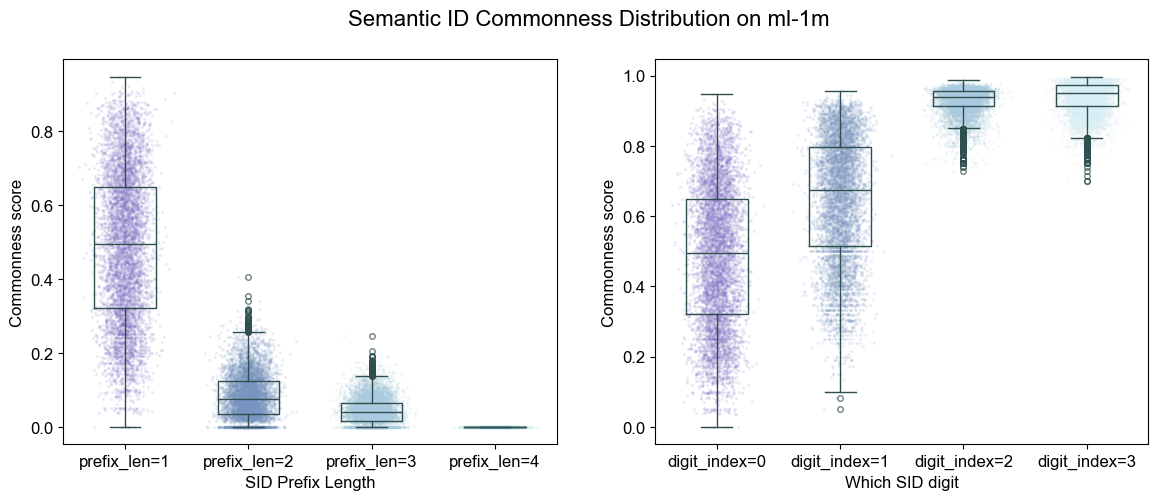

In [150]:

plt.figure(figsize=(14, 5))
medianprops = dict(linewidth=1, color='darkslategrey')
boxprops = dict(linewidth=1, color='darkslategrey')
whiskerprops = dict(linewidth=1, color='darkslategrey')
capprops = dict(linewidth=1, color='darkslategrey')
flierprops = dict(marker='o', markersize=4, markeredgecolor='darkslategrey', alpha=0.7)

plt.subplot(1, 2, 1)
for i in range(NUM_LAYERS):
    plt.boxplot(prefix_commonness[i], positions=[i], widths=0.5, 
                medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)
    jitter = np.random.normal(0, 0.1, size=len(prefix_commonness[i]))
    plt.scatter([i + j for j in jitter], prefix_commonness[i], alpha=0.1, s=2, c=layer_palette[i])
plt.xticks(ticks=list(range(NUM_LAYERS)), labels=[f"prefix_len={i+1}" for i in range(NUM_LAYERS)])
plt.xlabel("SID Prefix Length")
plt.ylabel("Commonness score")

plt.subplot(1, 2, 2)
for i in range(NUM_LAYERS):
    plt.boxplot(singledigit_commonness[i], positions=[i], widths=0.5, 
                medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)
    # add random jitter
    jitter = np.random.normal(0, 0.1, size=len(singledigit_commonness[i]))
    plt.scatter([i + j for j in jitter], singledigit_commonness[i], alpha=0.1, s=2, c=layer_palette[i])
plt.xticks(ticks=list(range(NUM_LAYERS)), labels=[f"digit_index={i}" for i in range(NUM_LAYERS)])
plt.xlabel("Which SID digit")
plt.ylabel("Commonness score")

plt.suptitle(f"Semantic ID Commonness Distribution on {DATASET}", fontsize=16)
plt.savefig(f"{SAVE_ROOT}/SID_commonness_{DATASET}.png", dpi=300, bbox_inches='tight')

plt.show()


## 3. Long tail item improvement
Here we recreate figure X in my plot post about examining the performance improvement for different groups of movies based on their appearances in the user history.

### 3.1 Visualize the long-tail and binning for MovieLens dataset

In [51]:
BIN_THRES = [0.25, 0.75]

mov_bin_data_20m = pickle_load("./output/movie_binning_ml-20m.pkl")
cum_freq_20m = mov_bin_data_20m["cumulative_frequency"]
bins = mov_bin_data_20m["movie_id_2_bins"]
bin_indices_20m = np.asarray(list(bins.values()))

mov_bin_data_1m = pickle_load("./output/movie_binning_ml-1m.pkl")
cum_freq_1m = mov_bin_data_1m["cumulative_frequency"]
bins = mov_bin_data_1m["movie_id_2_bins"]
bin_indices_1m = np.asarray(list(bins.values()))

Bin 0: from 0 to 154
Bin 1: from 154 to 1007
Bin 2: from 1007 to 3883
Bin 0: from 0 to 164
Bin 1: from 164 to 1554
Bin 2: from 1554 to 27278


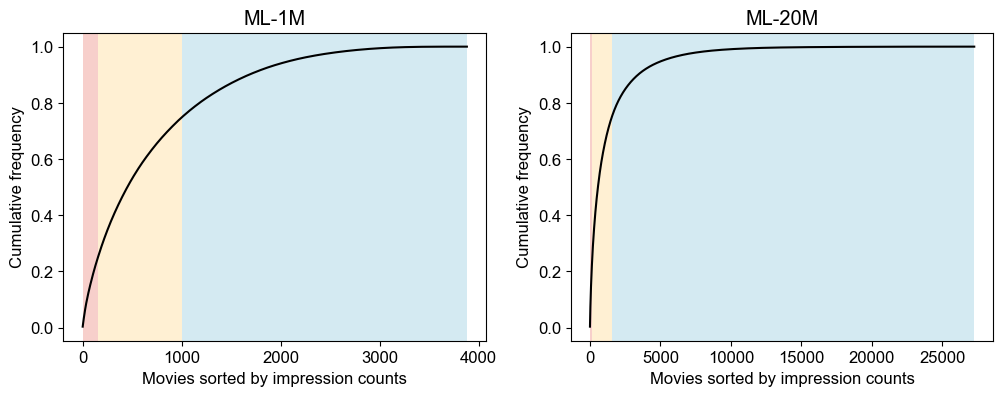

In [132]:
# plot cum frequency colored by bins
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cum_freq_1m, color='black')
prev_start = 0
for i in range(len(BIN_THRES) + 1):
    curr_end = prev_start + np.sum(bin_indices_1m == i)
    print(f"Bin {i}: from {prev_start} to {curr_end}")
    plt.axvspan(prev_start, curr_end, facecolor=clr_palette[f"bin{i}"], alpha=0.3) 
    prev_start += np.sum(bin_indices_1m == i)
plt.xlabel("Movies sorted by impression counts")
plt.ylabel("Cumulative frequency")
plt.title("ML-1M")

plt.subplot(1, 2, 2)
plt.plot(cum_freq_20m, color='black')
prev_start = 0
for i in range(len(BIN_THRES) + 1):
    curr_end = prev_start + np.sum(bin_indices_20m == i)
    print(f"Bin {i}: from {prev_start} to {curr_end}")
    plt.axvspan(prev_start, curr_end, facecolor=clr_palette[f"bin{i}"], alpha=0.3) 
    prev_start += np.sum(bin_indices_20m == i)
plt.xlabel("Movies sorted by impression counts")
plt.ylabel("Cumulative frequency")
plt.title("ML-20M")

# save transparent background
plt.savefig(f"{SAVE_ROOT}/movie_bins_cumfreq.png", 
            dpi=300, 
            bbox_inches='tight', 
            # transparent=True
            )
plt.show()



### 3.2 Visualize model perf by bins

In [106]:
DATASET = "ml-1m"
root = "../logs_anal_binnedeval/{}-l200/{}"
fs = ["hstu-sampled-softmax-n128-final-anal-binnedeval-BL.log",
      "hstu-sampled-softmax-n128-final-anal-binnedeval-SID.log"
      ]
model_names = ["baseline", 
                "prefixN-indEmb"
            ]
NUM_BINS = 3
eval_metrics = ["NDCG@10", "NDCG@50", "HR@10", "HR@50", "MRR"]
# train_metrics = ["", "weight alpha"]

In [107]:
eval_met_full = []
train_loss_full = []
for fname in fs:
    with open(root.format(DATASET, fname), 'r') as f:
        content = f.readlines()

    eval_met_vals = {met: {f"bin{i}": [] for i in range(NUM_BINS)} for met in eval_metrics}
    train_loss = []
    for ln in content:
        # eval lines
        if ln.startswith("rank 0: eval @ epoch"):
            for met in eval_metrics:
                met_val = -1.0 # maybe there was one split without any sampled movies.
                if met in ln:
                    met_val = float(ln.split(met)[1].split(",")[0].strip())
                success = False
                for i in range(NUM_BINS):
                    if f"bin {i}" in ln:
                        eval_met_vals[met][f"bin{i}"].append(met_val)
                        success = True
                        break
                if not success:
                    print(f"Warning: {met} value not found in line: {ln}")
                
        # train loss lines
        elif ln.startswith(" rank: 0, batch-stat (train):"):
            loss = float(ln.split(":")[-1].strip())
            train_loss.append(loss)
    eval_met_full.append(eval_met_vals)
    train_loss_full.append(train_loss)

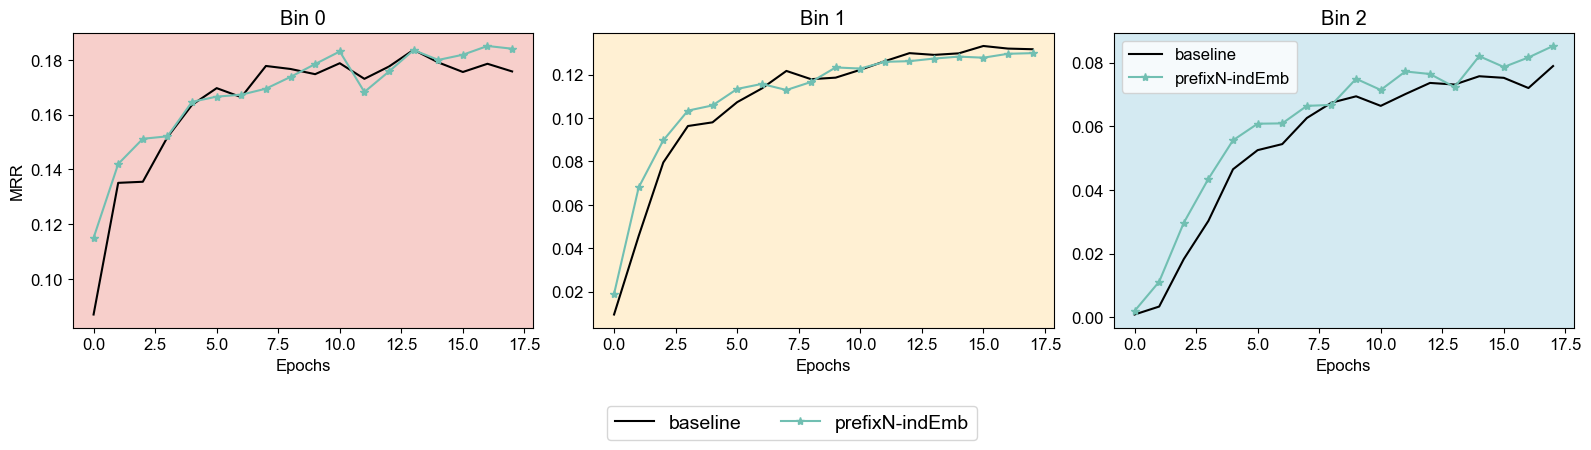

In [131]:
PLOT_METRIC = "MRR"

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
# plot eval metric row first with 3 bins as 3 columns of subplots
for bin_i in range(NUM_BINS):
    ax = axes[bin_i]
    for i, models in enumerate(eval_met_full):
        met_vals = models[PLOT_METRIC][f"bin{bin_i}"]
        ax.plot(
            met_vals, 
            label=model_names[i], 
            color=clr_palette[model_names[i]], 
            marker=icon_palette[model_names[i]], 
            linestyle=line_palette[model_names[i]]
        )
    xmin_data, xmax_data = ax.get_xlim()
    # ax.axvspan(xmin_data, xmax_data, facecolor=clr_palette[f"bin{bin_i}"], alpha=0.3)
    ax.set_title(f"Bin {bin_i}")
    if bin_i == 0:
        ax.set_ylabel(PLOT_METRIC)
    ax.set_xlabel("Epochs")
    if bin_i == NUM_BINS - 1:
        ax.legend()
    ax.patch.set_facecolor(clr_palette[f"bin{bin_i}"])
    # ax.grid()
    ax.patch.set_alpha(0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

plt.savefig(f"{SAVE_ROOT}/binned_eval_{PLOT_METRIC}_{DATASET}.png", 
            dpi=300, 
            bbox_inches='tight', 
            facecolor=fig.get_facecolor(),
            # transparent=True
            )
plt.tight_layout()
plt.show()